In [1]:
%reset
%load_ext autoreload
%autoreload 2
%matplotlib qt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%qtconsole

In [ ]:
pwd


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import os
from dataIO.span import span
from dataIO.fn_add_subfix import fn_add_subfix

from skimage import data as skidata
from skimage import img_as_float

from astropy.io import fits
from pyProfile.psd import plot_sig_psd,psd2prof,psd
from pyProfile.profile import make_signal,line

from IPython.display import display
from plotting.backends import maximize

# Meaning of frequency and PSD vectors 

There are several ways to define power over an interval of frequencies and corresponding power spectral density.

We define PSD as $\frac{FFT^2}{N} \Delta = \frac{FFT^2}{N^2} L $. This definition allows to plot curves with different frequency spacing in a way they overlap. 

In `pySurf.psd` this is implemented as

    psd  = 2*np.abs(np.fft.rfft(y))**2*normfactor
    psd[0]=psd[0]/2  #the first component is not doubled


With this definition, the integral of PSD over frequency is equal to rms of surface: $\sigma ^2=\int{dx PSD}=\Delta \sum{PSD} $
in code:

    np.trapz(p[1:],f[1:])
    p[1:].sum()/L   #L=1/f[1]


### Normalization

Note that the normalization of the PSD is arbitrary, see Press et Al. Numerica Recipes (NR) sec. 13.4
In general PSD can be expressed as $P=\alpha FFT^2$, with $\alpha$ normalization factor chosen between different formulas implemented in function 
    
    normPSD(N,L,form=norm)
    
Default choice above is form=1 corresponding to the above normalization factor $\alpha = L/{N^2}$

The function ``test_psd_normalization`` verifies that integral of PSD is equal to rms of profile.
Note also the role of 0-th element. rms of a signal is different from its standard deviation, with the first is the square-root-sum fo differences with respect to zero, the second to the average.

psd[0] represent the constant term avg of the signal: $ rms^2=standard deviation^2+avg^2$


In [6]:
def test_psd_normalization(x,y,wfun=None,norm=1,**kwargs):
    """Calculate PSD with a given normalization and
    compare its integral over frequency and sum to
    rms square and standard deviation (they differ for rms including also offset, while stddev being referred to mean."""
    
    f,p=psd(x,y,wfun=wfun,norm=norm,**kwargs)
    
    print ("== Quantities calculated from profile ==")
    print ("devstd**2=",np.std(y)**2, '(devstd=%f5.3)'%np.std(y))
    print ("rms**2=",(y**2/len(x)).sum())  #, '(rms=%f5.3)'%np.std(y)
    print ("== Quantities calculated from PSD ==")
    print ("sum of PSD is ",p[1:].sum())
    print ("integral of PSD (as sum*deltaf) is ",p[1:].sum()/span(x,1)) #span(x,size=1)=1/L
    print ("integral trapz: ",np.trapz(p[1:],f[1:]))
    print ("psd[0]*deltaf=%f (integral including:%f)"%(p[0]*f[1],p.sum()/span(x,1)))
    print ("#--------")
    
    return f,p        

== Quantities calculated from profile ==
devstd**2= 50.359904293103405 (devstd=7.0964715.3)
rms**2= 50.39218036392025
== Quantities calculated from PSD ==
sum of PSD is  1510.7971287931425
integral of PSD (as sum*deltaf) is  50.35990429310475
integral trapz:  50.22318056282331
psd[0]*deltaf=0.032212 (integral including:50.392180)
#--------


Let's test with a quite general (not integer fraction, no offset or tilt) pure sine wave:

In [8]:
x,y=make_signal(amp=10.,L=30.,N=501,nwaves=5.8,ystartend=(0,0),noise=0)
f,p=test_psd_normalization(x,y,norm=1)

== Quantities calculated from profile ==
devstd**2= 50.359904293103405 (devstd=7.0964715.3)
rms**2= 50.39218036392025
== Quantities calculated from PSD ==
sum of PSD is  1510.7971287931425
integral of PSD (as sum*deltaf) is  50.35990429310475
integral trapz:  50.22318056282331
psd[0]*deltaf=0.032212 (integral including:50.392180)
#--------


Alternative normalizations are given by other choices of the normalization factor

    if form==0:
        factor=1. #units: [Y**2] no normalization. "sum squared amplitude" in NR 13.4.1
    if form==1:
        factor=1./N**2*L #[Y**2][X] This has the advantage that measurements on same range with different number of points match
        #and it is the way it is usually plotted. The rms is the integral of PSD over frequency rather than the sum.
    elif form==2:
        factor=1./N**2 #[Y**2] here rms is the sum of PSD, this is RA normalization (however it differs in RA when a window is used).
        #"" 13.4.5 in NR
    elif form==3:
        factor=1./N #[Y**2] not sure what this is for, "mean squared amplitude" in NR 13.4.2
                    #and in formula 12.1.10 as discrete form of Parsifal's theorem

In [10]:
for nn in range(0,4):
    print "norm type= %s"%nn
    test_psd_normalization(x,y,norm=nn)

norm type= 0
== Quantities calculated from profile ==
devstd**2= 50.3599042931 (devstd=7.0964715.3)
rms**2= 50.3921803639
== Quantities calculated from PSD ==
sum of PSD is  12640386.3375
integral of PSD (as sum*deltaf) is  421346.211249
integral trapz:  420202.284815
psd[0]*deltaf=269.505191 (integral including:421616.255451)
#--------
norm type= 1
== Quantities calculated from profile ==
devstd**2= 50.3599042931 (devstd=7.0964715.3)
rms**2= 50.3921803639
== Quantities calculated from PSD ==
sum of PSD is  1510.79712879
integral of PSD (as sum*deltaf) is  50.3599042931
integral trapz:  50.2231805628
psd[0]*deltaf=0.032212 (integral including:50.392180)
#--------
norm type= 2
== Quantities calculated from profile ==
devstd**2= 50.3599042931 (devstd=7.0964715.3)
rms**2= 50.3921803639
== Quantities calculated from PSD ==
sum of PSD is  50.3599042931
integral of PSD (as sum*deltaf) is  1.67866347644
integral trapz:  1.67410601876
psd[0]*deltaf=0.001074 (integral including:1.679739)
#-----

The newly added flag `rmsnorm` in PSD rescales the PSD so that its "integral" is equal to rms square of the profile. This is expected to be 1  The way 'integration' is intended depends on the definition of normalization in the choices above, however the rescaling is 

### test rmsnorm

== Quantities calculated from profile ==
devstd**2= 50.359904293103405 (devstd=7.0964715.3)
rms**2= 50.39218036392025
== Quantities calculated from PSD ==
sum of PSD is  1510.7971287931425
integral of PSD (as sum*deltaf) is  50.35990429310475
integral trapz:  50.22318056282331
psd[0]*deltaf=0.032212 (integral including:50.392180)
#--------
== Quantities calculated from profile ==
devstd**2= 50.359904293103405 (devstd=7.0964715.3)
rms**2= 50.39218036392025
== Quantities calculated from PSD ==
sum of PSD is  1510.7971287931425
integral of PSD (as sum*deltaf) is  50.35990429310475
integral trapz:  50.22318056282331
psd[0]*deltaf=0.032212 (integral including:50.392180)
#--------
== Quantities calculated from profile ==
devstd**2= 50.359904293103405 (devstd=7.0964715.3)
rms**2= 50.39218036392025
== Quantities calculated from PSD ==
sum of PSD is  1510.7971287931634
integral of PSD (as sum*deltaf) is  50.35990429310545
integral trapz:  50.25933906616243
psd[0]*deltaf=0.000023 (integral inclu

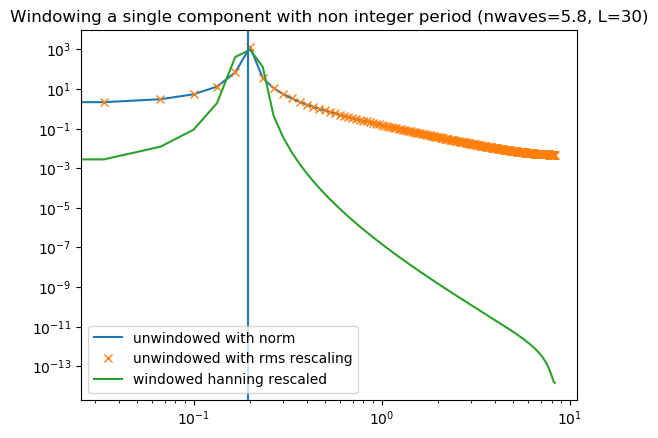

In [9]:
#first two are exactly equal (indeed no need of rescaling), the third applies a rescaling to the windowed function 
plt.figure()
plt.title('Windowing a single component with non integer period (nwaves=5.8, L=30)')
plt.loglog()
x,y=make_signal(amp=10.,L=30.,N=501,nwaves=5.8,ystartend=(0,0),noise=0)
f,p=test_psd_normalization(x,y,norm=1)
plt.plot(f,p,label='unwindowed with norm')
f,p=test_psd_normalization(x,y,norm=1,rmsnorm=True)
plt.plot(f,p,'x',label='unwindowed with rms rescaling')
f,p=test_psd_normalization(x,y,norm=1,rmsnorm=True,wfun=np.hanning)
plt.plot(f,p,label='windowed hanning rescaled')
plt.axvline(5.8/30)
plt.legend(loc=0)
display(plt.gcf())

## Role of zero-th element

Note that rms is same as standard deviation only if array has mean zero. Integral of psd gives rms.
Component zero contains the constant term of the signal (square of average value). As a consequence integral of `psd[1:]` is standard deviation.

In [15]:
def rms(y):
    return np.sqrt((y**2/len(y)).sum())

exact number of wavelengths:
rms(y)**2= 49.9
== Quantities calculated from profile ==
devstd**2= 49.9 (devstd=7.0639935.3)
rms**2= 49.9
== Quantities calculated from PSD ==
sum of PSD is  1497.0000118989014
integral of PSD (as sum*deltaf) is  49.90000039663005
integral trapz:  49.800182759760965
psd[0]*deltaf=0.000000 (integral including:49.900000)
#--------
zero extremes:
rms(y)**2= 50.39215683595933
== Quantities calculated from profile ==
devstd**2= 50.35988797822677 (devstd=7.0964705.3)
rms**2= 50.392156835959334
== Quantities calculated from PSD ==
sum of PSD is  1510.7990868517634
integral of PSD (as sum*deltaf) is  50.35996956172544
integral trapz:  50.223052615891696
psd[0]*deltaf=0.032204 (integral including:50.392238)
#--------
unleveled extremes:
rms(y)**2= 204.45735167397535
== Quantities calculated from profile ==
devstd**2= 68.04346984543803 (devstd=8.2488475.3)
rms**2= 204.45735167397532
== Quantities calculated from PSD ==
sum of PSD is  2041.30601618389
integral of PSD

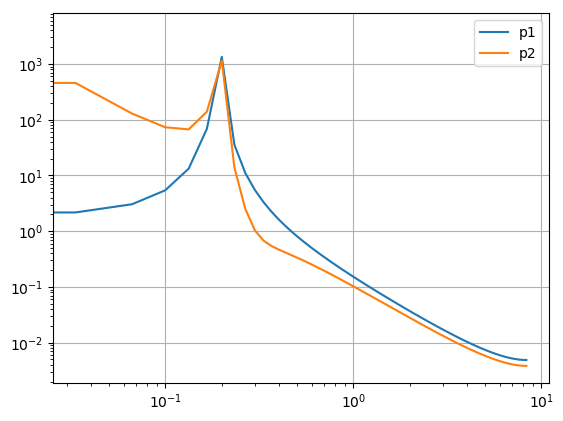

In [16]:
print ('exact number of wavelengths:')
x,y=make_signal(amp=10.,L=30.,N=500,nwaves=5.,ystartend=(0,0),noise=0)
print ("rms(y)**2=",rms(y)**2)
f,p=test_psd_normalization(x,y)
print ('zero extremes:')
x,y=make_signal(amp=10.,L=30.,N=500,nwaves=5.8,ystartend=(0,0),noise=0)
print ("rms(y)**2=",rms(y)**2)
f,p=test_psd_normalization(x,y)
print ('unleveled extremes:')
x,y=make_signal(amp=10.,L=30.,N=500,nwaves=5.8,ystartend=(3,20),noise=0)
print ("rms(y)**2=",rms(y)**2)
f2,p2=test_psd_normalization(x,y)

plt.clf()
plt.plot(f,p,label='p1')  #/len(x)
plt.plot(f2,p2,label='p2')  #/len(x)
plt.loglog()
plt.grid(1)
plt.legend(loc=0)
display(plt.gcf())

The following helps to test in case normalization is lost:

In [18]:
print (np.std(y)**2)

68.04346984543803


In [20]:
a=np.trapz(np.abs(np.fft.rfft(y))**2/len(x)**2)*2
print (a)

204.45735167397524


In [23]:
b=np.trapz(np.abs(np.fft.rfft(y))**2/len(x)**2,
           np.fft.fftfreq(len(x),span(x,1)/len(x))[:251])*2
print (b, b/(f[2]-f[1]))

6.813110768481306 204.80292891226372


In [25]:
b=np.trapz(np.abs(np.fft.rfft(y))**2/len(x)**2*span(x,1),
           np.fft.rfftfreq(len(x),span(x,1)/len(x)))*2
print (b, b/(f[2]-f[1]))

b=np.trapz(np.abs(np.fft.rfft(y)[1:])**2/len(x)**2,
           np.fft.rfftfreq(len(x),span(x,1)/len(x))[1:])*2
print (b, b/(f[2]-f[1]))

204.45735167397527 6146.012575369998
2.01399161434983 60.54083009067625


In [27]:
print (a/b,b/a)

101.51847218091794 0.009850424051081871


In [28]:
print (f[2]-f[1],x[2]-x[1])

0.03326666666666667 0.06012024048096192


## Examples of PSD calculation

Make a sin wave with a few points and calculate PSD.
This is the easiest case, a single component with integer number of wavelengths (n=5)
and no offset or tilt, still PSD is not a delta!

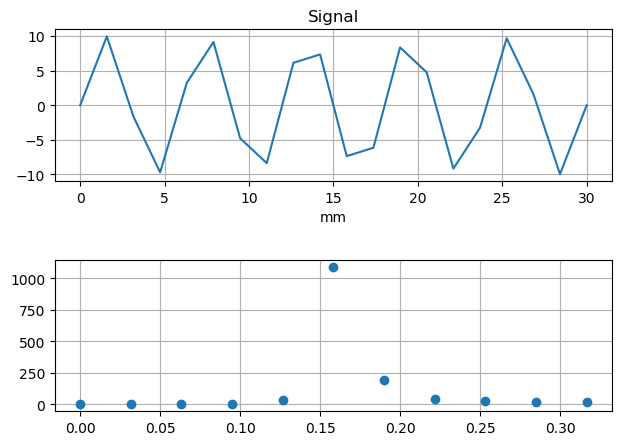

In [46]:
plt.ion()
x,y=make_signal(amp=10.,L=30.,N=20,nwaves=5.,ystartend=(0,0),noise=0)
f,p=psd(x,y)
fig=plt.figure(11)
plt.clf()
axes=plot_sig_psd(x,y,label='5.0')
plt.cla() 
plt.plot(f,p,'o')
plt.grid()
plt.show()
#ax2.set_xscale('linear')
#ax2.set_yscale('linear
display(plt.gcf())

In [48]:
print ("rms**2=",rms(y)**2, '(rms=%f5.3)'%rms(y))
print ("integral of PSD is ",p.sum()*f[1])

rms**2= 47.499999999999986 (rms=6.8920245.3)
integral of PSD is  45.405255947237244


In [49]:
test_psd_normalization(x,y);

== Quantities calculated from profile ==
devstd**2= 47.499999999999986 (devstd=6.8920245.3)
rms**2= 47.499999999999986
== Quantities calculated from PSD ==
sum of PSD is  1433.8501878074924
integral of PSD (as sum*deltaf) is  47.79500626024974
integral trapz:  45.119597166179815
psd[0]*deltaf=0.000000 (integral including:47.795006)
#--------


In [51]:
#print all Fourier components
p=np.fft.fft(y,len(x))
print (p)

[ 2.48689958e-14+0.00000000e+00j  2.35945359e-01-1.48970037e+00j
  1.06735915e+00-3.28499368e+00j  3.06405519e+00-6.01354691e+00j
  8.79251002e+00-1.21018518e+01j  6.03410264e+01-6.03410264e+01j
 -2.88058555e+01+2.09286791e+01j -1.56605667e+01+7.97945729e+00j
 -1.24087614e+01+4.03185097e+00j -1.11942647e+01+1.77299735e+00j
 -1.08628958e+01+1.59872116e-14j -1.11942647e+01-1.77299735e+00j
 -1.24087614e+01-4.03185097e+00j -1.56605667e+01-7.97945729e+00j
 -2.88058555e+01-2.09286791e+01j  6.03410264e+01+6.03410264e+01j
  8.79251002e+00+1.21018518e+01j  3.06405519e+00+6.01354691e+00j
  1.06735915e+00+3.28499368e+00j  2.35945359e-01+1.48970037e+00j]


In [52]:
#With even number of points, these are symmetries:
print (p[0],p[10])
print (p[1],p[-1])

(2.4868995751603507e-14+0j) (-10.862895751129154+1.5987211554602254e-14j)
(0.23594535899015412-1.4897003677048914j) (0.23594535899018165+1.489700367704943j)


In [53]:
#xorresponding frequencies are:
ff=np.fft.fftfreq(len(x),span(x,1)/len(x))
print (ff[0],ff[10])
print (ff[1],ff[-1])

0.0 -0.3333333333333333
0.03333333333333333 -0.03333333333333333


In [54]:
#With odd number of points it is
p=np.fft.fft(y[:-1],len(x[:-1]))
print (p[0],p[10])
print (p[1],p[-1])

(7.416289804496046e-14+0j) (5.254005943226132e-14+4.085620730620576e-14j)
(9.388847457313936e-15+5.417888360170764e-14j) (9.388847457313936e-15-5.417888360170764e-14j)


In [55]:
#where symmetry is the same, but the central point is missing
print (p[0],p[9:11])
print (p[1],p[-1])

(7.416289804496046e-14+0j) [5.25400594e-14-4.08562073e-14j 5.25400594e-14+4.08562073e-14j]
(9.388847457313936e-15+5.417888360170764e-14j) (9.388847457313936e-15-5.417888360170764e-14j)


## Fig. 11: Effects of leveling

In [56]:
#generic messy signal, note that rectangluar integral works better than trapezioidal integral
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.4,ystartend=(29,42),noise=5)
f,p=test_psd_normalization(x,y)

== Quantities calculated from profile ==
devstd**2= 65.19262527929595 (devstd=8.0741955.3)
rms**2= 1551.7879161561925
== Quantities calculated from PSD ==
sum of PSD is  1955.788305734216
integral of PSD (as sum*deltaf) is  65.19294352447386
integral trapz:  60.62321029222339
psd[0]*deltaf=1479.162314 (integral including:1551.788234)
#--------


In [57]:
#usually all three give similar results, with the first two being exactly 
#  equivalent. The third one gives a different number, very different
#  if component 0 is large.
print (np.trapz(p[1:],f[1:])) #this gives correct result, but formula miss a /L
#factor respect Press et al for normalization.
print (np.trapz(p[1:]/span(x,1)))  #indeed the formula as in ref. works if 
#integral with default dx=1.
print (p.sum()-p[0]) #this is because formula is defined on 
#discrete sums, not on integrals.

60.62321029222339
60.927849539923
1955.7883057342406


The simplest sine wave has wavelength integer fraction of the scanned length L.
Extremes are 0.

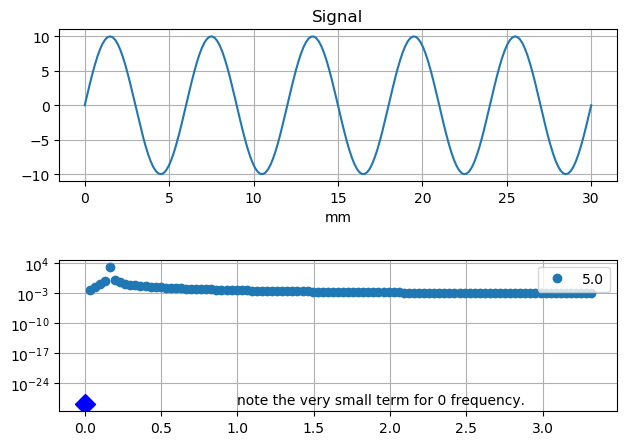

rms**2= 49.75000000000004 (rms=7.0533685.3)
integral of PSD is  1492.500469246943
psd[0]= 1.1929943469657362e-29


In [59]:
#simplest sine wave
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.,ystartend=(0,0),noise=0)
f,p=psd(x,y)
fig=plt.figure(11)
plt.clf()
axes=plot_sig_psd(x,y)
plt.cla() 
plt.plot(f,p,'o',label='5.0')
plt.semilogy()
plt.grid()
plt.show()
#ax2.set_xscale('linear')
#ax2.set_yscale('linear
plt.plot(f[0],p[0],'Db',ms=10)
plt.legend(loc=0)
plt.annotate('note the very small term for 0 frequency.',(f[0],p[0]),(1.,p[0]))
display(plt.gcf())
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p.sum()-p[0])
print ("psd[0]=",p[0])

In [60]:
plot_sig_psd??

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


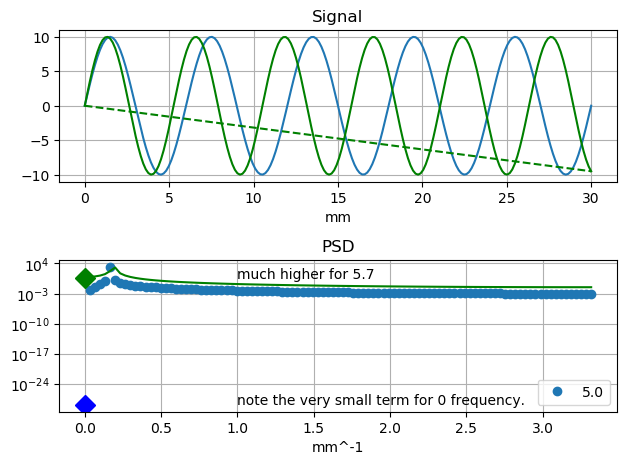

rms**2= 49.45742906246932 (rms=7.0325985.3)
integral of PSD is  1483.7376807205083
psd[0]= 3.445934192325685


In [61]:
#wave of non multiple frequency

#%matplotlib inline
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(0,0),noise=0)
f,p=psd(x,y)
ax1,ax2=plot_sig_psd(x,y,label='5.7',c='g')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dg',ms=10)
plt.annotate('much higher for 5.7',(f[0],p[0]),(1.,p[0]))
plt.grid(1)
plt.show()
ax1.plot(x,line(x,y),'--g')

from IPython.display import display
display(plt.gcf())
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p.sum()-p[0])
print ("psd[0]=",p[0])

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


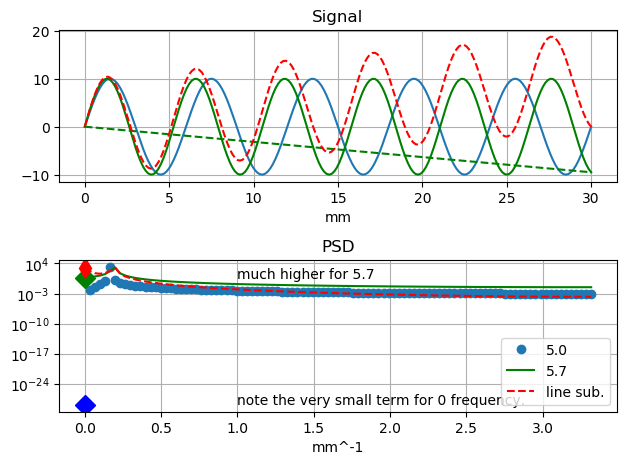

rms**2= 54.88309346243385 (rms=7.4083125.3)
integral of PSD is  1646.492888358324
psd[0]= 778.5259641218055


In [62]:
#subtract line from 5.7
y=y-line(x,y)
f,p=psd(x,y)
plot_sig_psd(x,y,label='line sub.',c='r',linestyle='--')
plt.gca().set_xscale('linear')
plt.plot(f[0],p[0],'dr',ms=10)
plt.legend(loc=0)
display(plt.gcf())
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p[1:].sum())
print ("psd[0]=",p[0])

In [63]:
plt.savefig(os.path.join(outfolder,'leveling.png'))

NameError: name 'outfolder' is not defined

## Fig.12, 13: Effects of windowing

### Compare with RA functions

In [71]:
##simplified version, gives same result if no window and 1 dim

def components(d):
    """Want to return Fourier components with optional window
    Application note: These components are dependent on sampling!
    This means you can *not* interpolate these components onto other
    frequency grids!
    """

    #Compute Fourier components
    return np.fft.fftn(d)/np.size(d)

def realPSD(d,win=1,dx=1.):
    """This function returns the PSD of a real function
    Gets rid of zero frequency and puts all power in positive frequencies
    Returns only positive frequencies
    """
    #Get Fourier components
    c = components(d)

    #Reform into PSD
    f = np.fft.fftfreq(np.size(c),d=dx)
    f = f[:int(np.size(c)/2)]
    c = c[:int(np.size(c)/2)]
    c[0] = 0.
    c = c*np.sqrt(2.)

    return f,np.abs(c)**2

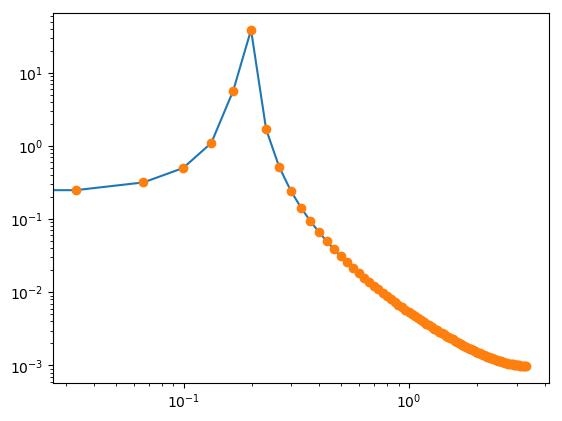

In [72]:
#match very well, but not exactly if no windowing
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(0,0),noise=0)
f,p=psd(x,y,norm=2)
f1,p1=realPSD(y,dx=x[1]-x[0])
plt.figure()
plt.loglog()
plt.plot(f,p)
plt.plot(f1,p1,'o')

display(plt.gcf())

In [73]:
#reintroduce complete version

def components(d,win=1):
    """Want to return Fourier components with optional window
    Application note: These components are dependent on sampling!
    This means you can *not* interpolate these components onto other
    frequency grids!
    """
    #Handle window
    if win is not 1:
        if np.size(np.shape(d)) is 1:
            win = win(np.size(d))/np.sqrt(np.mean(win(np.size(d))**2))
        else:
            win1 = win(np.shape(d)[0])
            win2 = win(np.shape(d)[1])
            win = np.outer(win1,win2)
            win = win/np.sqrt(np.mean(win**2))

    #Compute Fourier components
    return np.fft.fftn(d*win)/np.size(d)

def realPSD(d,win=1,dx=1.,axis=None):
    """This function returns the PSD of a real function
    Gets rid of zero frequency and puts all power in positive frequencies
    Returns only positive frequencies
    """
    
    #===========
    #THIS part updated 2017 
    if nans is True:
        d = stripnans(d0)
    else:
        d = d0
    if len(d) < minpx:
        return np.nan
    #============
    
    #Get Fourier components
    c = components(d,win=win)
    #Handle collapsing to 1D PSD if axis keyword is set
    if axis==0:
        c = c[:,0]
    elif axis==1:
        c = c[0,:]

    #Reform into PSD
    if np.size(np.shape(c)) is 2:
        f = [np.fft.fftfreq(np.shape(c)[0],d=dx)[:np.shape(c)[0]/2],\
                   np.fft.fftfreq(np.shape(c)[1],d=dx)[:np.shape(c)[1]/2]]
        c = c[:np.shape(c)[0]/2,:np.shape(c)[1]/2]
        c[0,0] = 0.
        #Handle normalization
        c = 2*c
        c[0,:] = c[0,:]/np.sqrt(2.)
        c[:,0] = c[:,0]/np.sqrt(2.)
        
    elif np.size(np.shape(c)) is 1:
        f = np.fft.fftfreq(np.size(c),d=dx)
        f = f[:np.size(c)/2]
        c = c[:np.size(c)/2]
        c[0] = 0.
        c = c*np.sqrt(2.)

    return f,np.abs(c)**2

In [79]:
#check details at Nyquist freq.
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(0,0),noise=0)

N=len(x)
L=span(x,1)
c = components(y)
f,p=psd(x,y,norm=2)
f1 = np.fft.fftfreq(np.size(c),d=x[1]-x[0])
f2 = np.fft.rfftfreq(np.size(c),d=x[1]-x[0])

print (f1[:int(np.size(c)/2)][-1],f2[-1])
#first terms excluded:
print (f1[int(np.size(c)/2)+1])
print (p[-1],len(p),len(c))

x,y=make_signal(amp=10.,L=30.,N=201,nwaves=5.7,ystartend=(0,0),noise=0)

N=len(x)
L=span(x,1)
c = components(y)
f,p=psd(x,y,norm=2)
f1 = np.fft.fftfreq(np.size(c),d=x[1]-x[0])
f2 = np.fft.rfftfreq(np.size(c),d=x[1]-x[0])

print (f1[:int(np.size(c)/2)][-1],f2[-1])
#first terms excluded:
print (f1[int(np.size(c)/2)+1])
print (p[-1],len(p),len(c))

3.2834999999999996 3.3166666666666664
-3.2834999999999996
0.0009872564285871202 101 200
3.283582089552239 3.316749585406302
-3.316749585406302
0.0009782085702676104 101 201


### Fig. 12: Effects on the simplest sinusoid

The simplest sine wave has wavelength integer fraction of the scanned length L.
Extremes are 0.

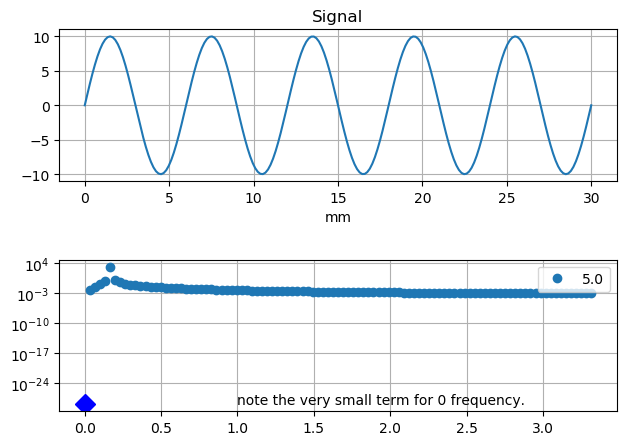

In [80]:
#simplest sine wave
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.,ystartend=(0,0),noise=0)
f,p=psd(x,y)
fig=plt.figure(12)
plt.clf()
axes=plot_sig_psd(x,y)
plt.cla() 
plt.plot(f,p,'o',label='5.0')
plt.semilogy()
plt.grid()
plt.show()
#ax2.set_xscale('linear')
#ax2.set_yscale('linear
plt.plot(f[0],p[0],'Db',ms=10)
plt.legend(loc=0)
plt.annotate('note the very small term for 0 frequency.',(f[0],p[0]),(1.,p[0]))
display(plt.gcf())

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


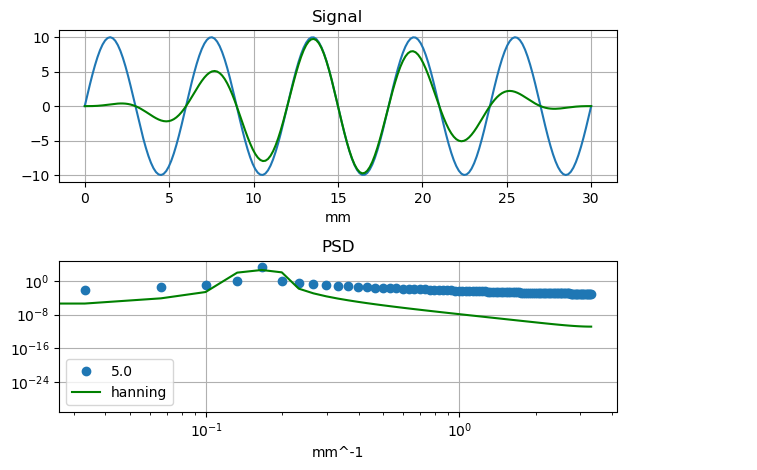

In [81]:
#%matplotlib inline
f,p=psd(x,y*np.hanning(len(y)))
plot_sig_psd(x,y*np.hanning(len(y)),label='hanning',c='g')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dg',ms=10)
plt.grid(1)
plt.show()
ax1.plot(x,line(x,y),'--g')
plt.legend(loc=0)
display(plt.gcf())

### Effect on non fractional sinusoid

In [82]:
fig=plt.figure(13)
plt.clf()
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(0,0),noise=0)
f,p=psd(x,y)
plot_sig_psd(x,y.,label='line sub.',c='b',linestyle='-')
ax2.set_xscale('linear')
plt.plot(f[0],p[0],'db',ms=10)
plt.legend(loc=0)
display(plt.gcf())
print "rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y)
print "integral of PSD is ",p[1:].sum()
print "psd[0]=",p[0]

SyntaxError: invalid syntax (<ipython-input-82-988360b6561a>, line 5)

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


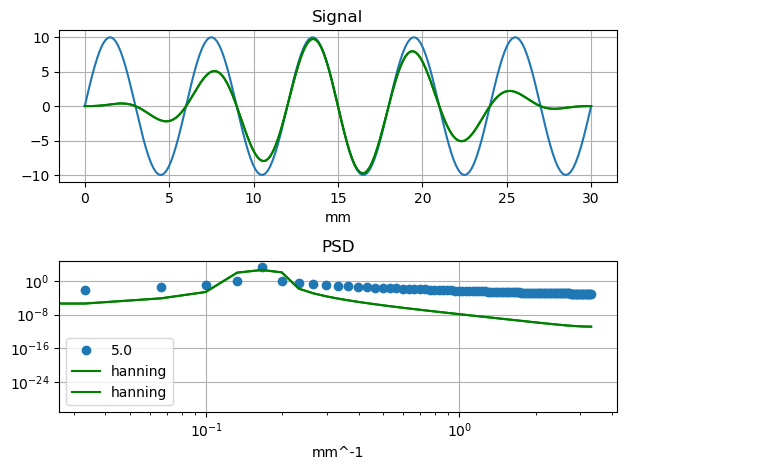

In [83]:
#hanning window
f,p=psd(x,y*np.hanning(len(y)))
plot_sig_psd(x,y*np.hanning(len(y)),label='hanning',c='g')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dg',ms=10)
plt.grid(1)
plt.show()
ax1.plot(x,line(x,y),'--g')
plt.legend(loc=0)
display(plt.gcf())

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


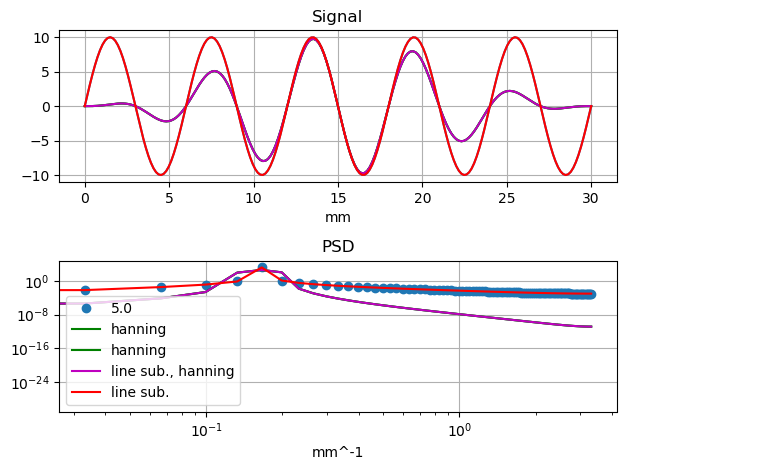

rms**2= 49.75 (rms=7.0533685.3)
integral of PSD is  1492.5004692469417
psd[0]= 1.645666952411343e-26


In [86]:
#line subtraction
y=y-line(x,y)
f,p=psd(x,y)
plot_sig_psd(x,y,label='line sub.',c='r',linestyle='-')
ax2.set_xscale('linear')
plt.plot(f[0],p[0],'dr',ms=10)
plt.legend(loc=0)
display(plt.gcf())
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p[1:].sum())
print ("psd[0]=",p[0])

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


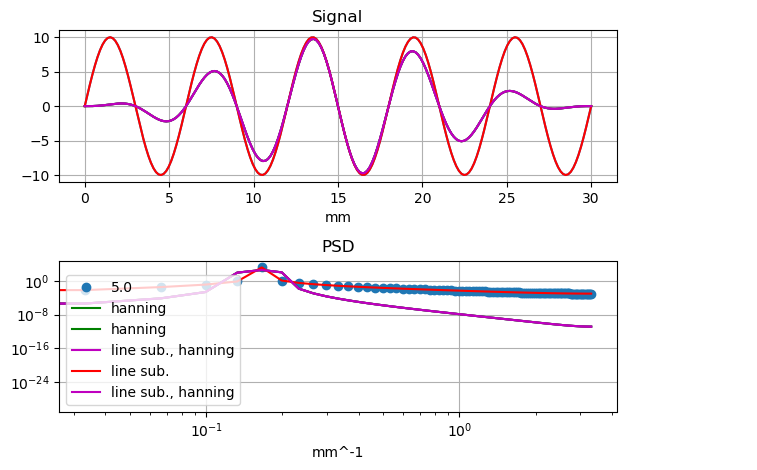

In [87]:
#add window
plot_sig_psd(x,y*np.hanning(len(y)),label='line sub., hanning',c='m')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dm',ms=10)
plt.grid(1)
plt.show()
plt.legend(loc=0)
display(plt.gcf())

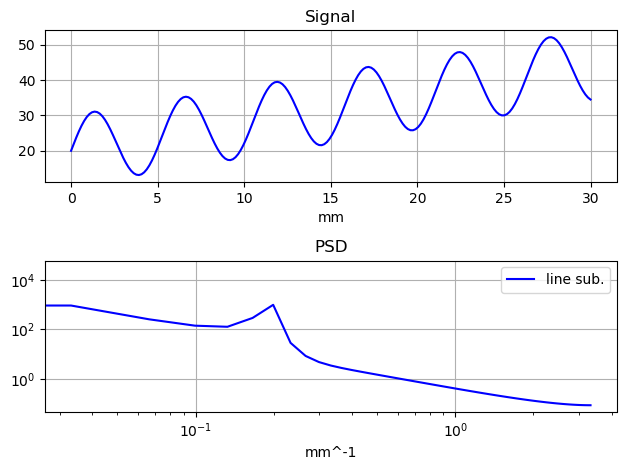

('rms**2=', 92.41925843701101, '(rms=9.6134945.3)')
('integral of PSD is ', 2772.6212642983)
('psd[0]=', 31374.16583826241)


In [89]:
fig=plt.figure(13)
plt.clf()
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(20,44),noise=0)
f,p=psd(x,y)
plot_sig_psd(x,y,label='line sub.',c='b',linestyle='-')
ax2.set_xscale('linear')
plt.plot(f[0],p[0],'db',ms=10)
plt.legend(loc=0)
display(plt.gcf())
print (("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y)))
print (("integral of PSD is ",p[1:].sum()))
print (("psd[0]=",p[0]))

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


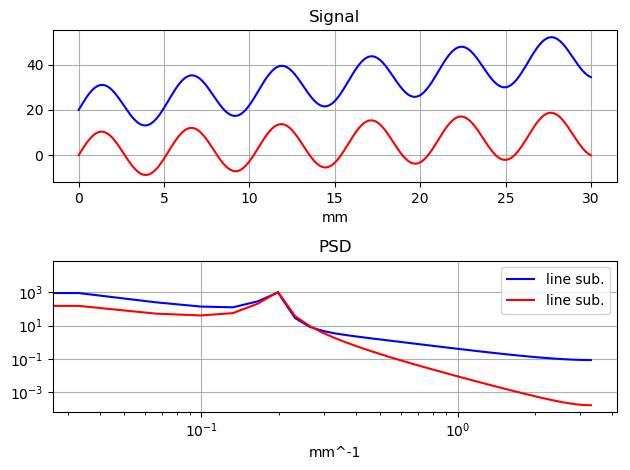

rms**2= 54.883093462433834 (rms=7.4083125.3)
integral of PSD is  1646.492888358324
psd[0]= 778.5259641218055


In [90]:
#line subtraction
y=y-line(x,y)
f,p=psd(x,y)
plot_sig_psd(x,y,label='line sub.',c='r',linestyle='-')
ax2.set_xscale('linear')
plt.plot(f[0],p[0],'dr',ms=10)
plt.legend(loc=0)
display(plt.gcf())
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p[1:].sum())
print ("psd[0]=",p[0])

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


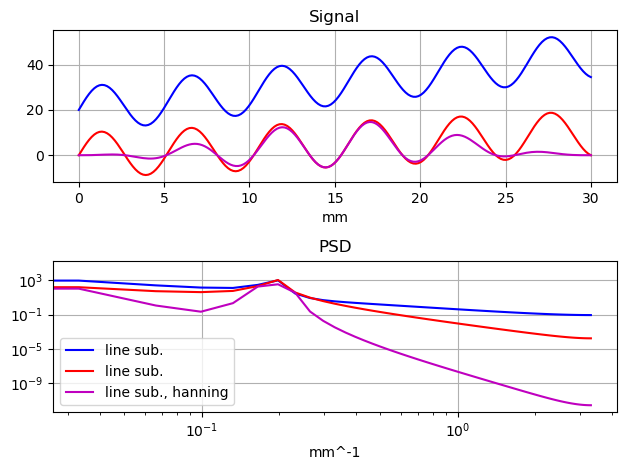

In [91]:
#add window
plot_sig_psd(x,y*np.hanning(len(y)),label='line sub., hanning',c='m')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dm',ms=10)
plt.grid(1)
plt.show()
plt.legend(loc=0)
display(plt.gcf())

C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


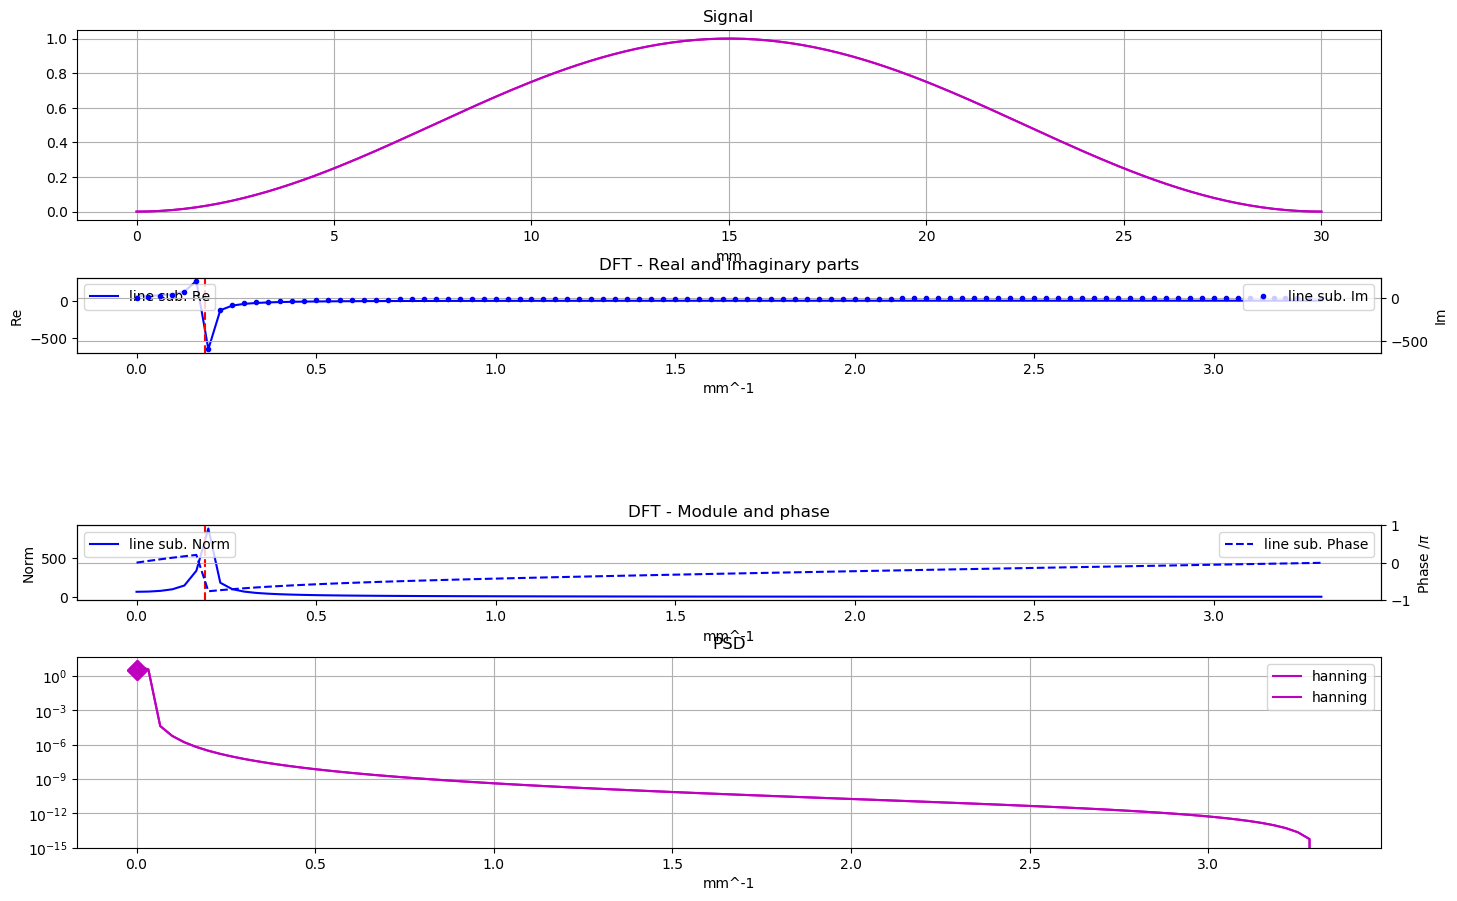

In [99]:
##fourier transform of hanning window
ax1,ax2=plot_sig_psd(x,np.hanning(len(y)),label='hanning',c='m')
#plt.cla() 
#ax1.plot(x,y)
#ax2.plot(f,p,'o')
ax2.set_xscale('linear')
plt.plot(f[0:1],p[0:1],'Dm',ms=10)
plt.grid(1)
plt.show()
plt.legend(loc=0)
maximize()
display(plt.gcf())

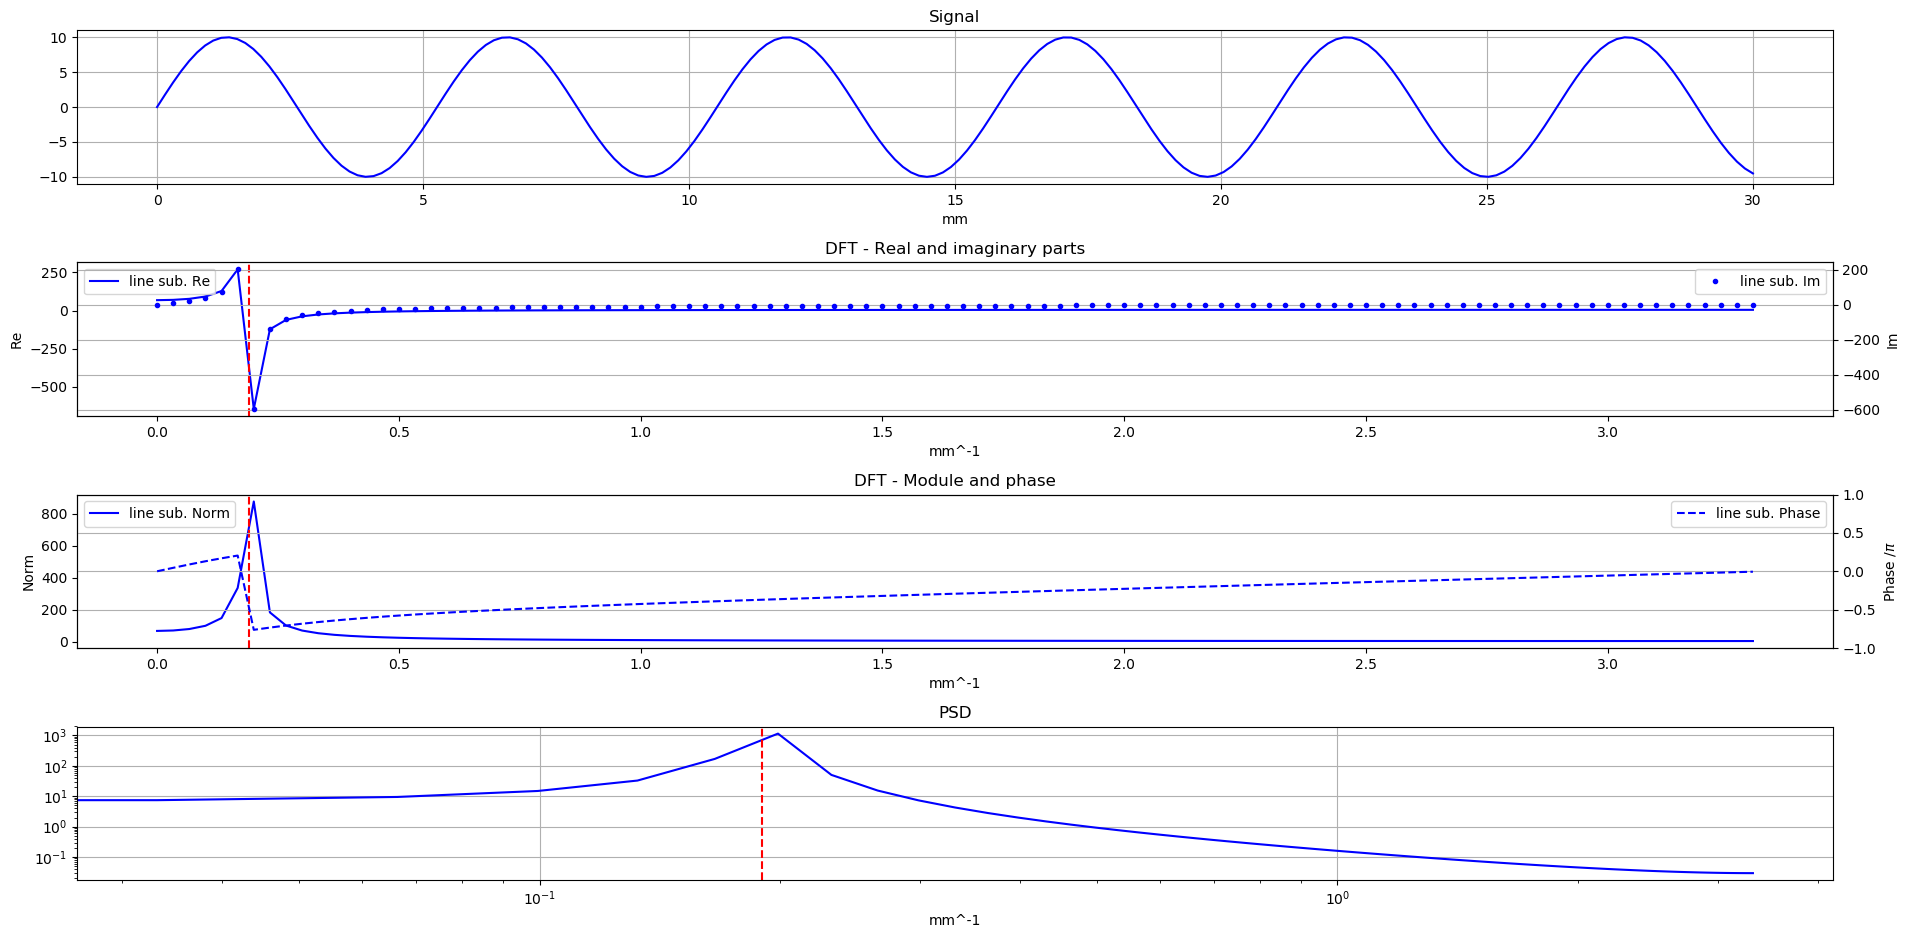

rms**2= 49.45742906246932 (rms=7.0325985.3)
integral of PSD is  1483.737680720508
psd[0]= 3.445934192325685


In [100]:
fig=plt.figure(13)
plt.clf()
x,y=make_signal(amp=10.,L=30.,N=200,nwaves=5.7,ystartend=(0,0),noise=0)
f,p=psd(x,y)
ax=plot_sig_psd(x,y,label='line sub.',c='b',realim=1,euler=1)
for a in ax[1:]:
    a.axvline(5.7/30,c='r',ls='--')
display(plt.gcf())
maximize()
print ("rms**2=",np.std(y)**2, '(rms=%f5.3)'%np.std(y))
print ("integral of PSD is ",p[1:].sum())
print ("psd[0]=",p[0])

In [101]:
ax1=ax[0]
ax2=ax[1]
aa=ax2.get_legend_handles_labels()
ax1.legend(*aa)

## Fine

In [252]:
%qtconsole

In [1]:
print not(False)
print not(0)
print not(1)
print 1 is True
print 1 is False
print 1 == True
print 1 == False
print 10 == True

True
True
False
False
False
True
False
False


In [157]:
#make a test signal
from pyProfile.psd import psd
from pyProfile.profile import line,make_signal

N=500
noise=0
amp=10.
L=30.
nwaves=5.8 #32
ystartend=(3,20)
#ystartend=(0,0)

outfolder='PSDtest'



In [25]:
%qtconsole

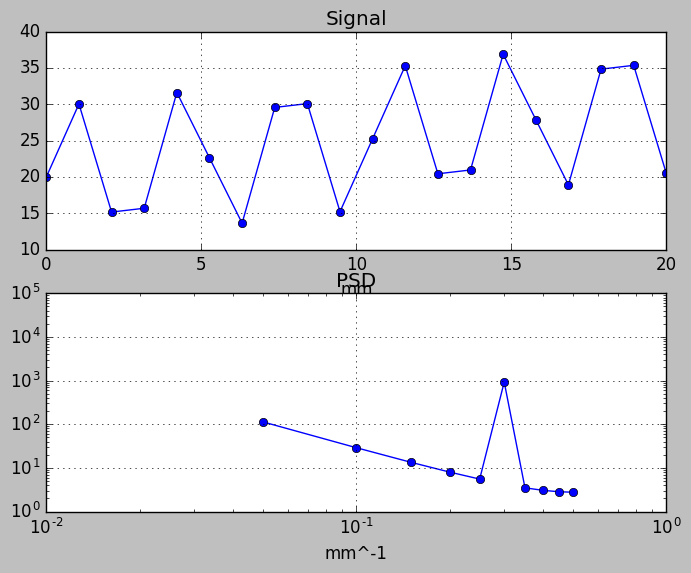

input profile:
signal rms is: 7.4422186392
rms**2= 55.3866182737
psd sum 1109.11740702
#--------------------


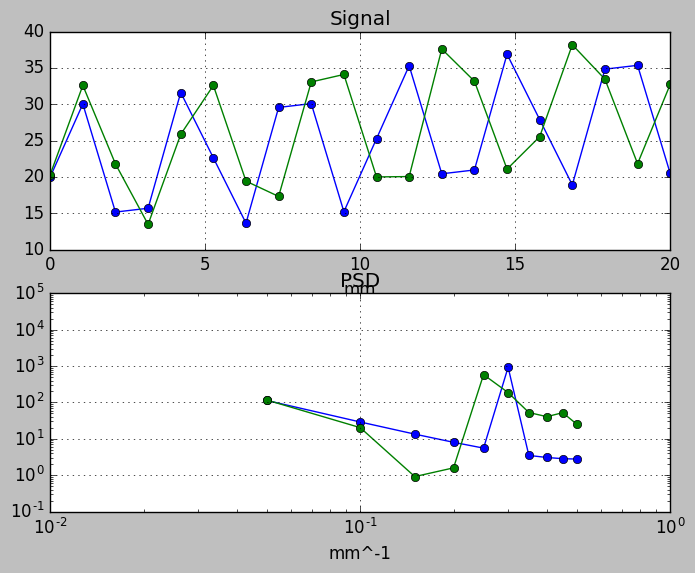

input profile:
signal rms is: 7.29832063025
rms**2= 53.2654840219
psd sum 1077.85407697
#--------------------


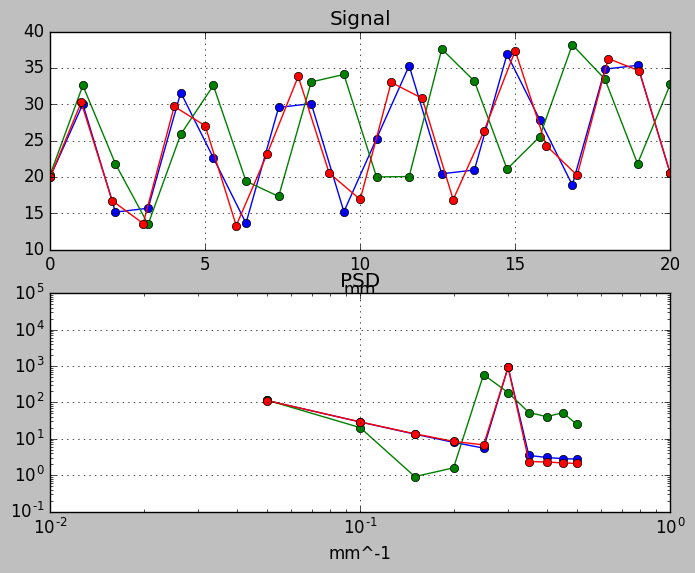

input profile:
signal rms is: 7.43819960529
rms**2= 55.3268133681
psd sum 1106.53626736
#--------------------


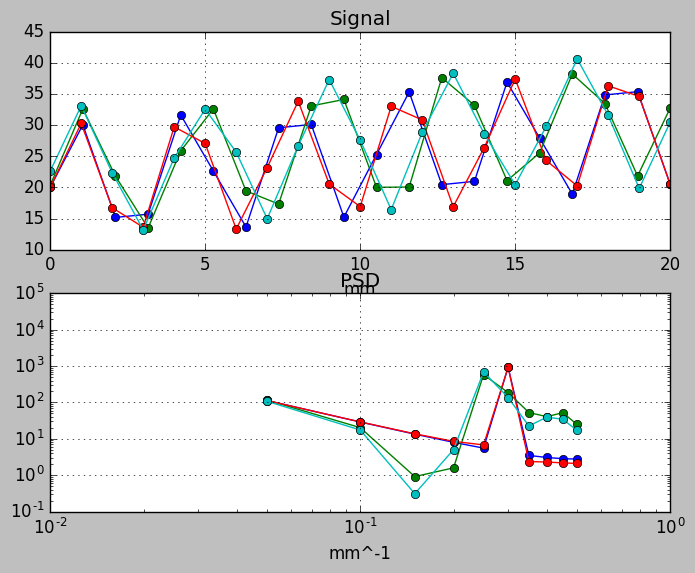

input profile:
signal rms is: 7.31488421632
rms**2= 53.5075310982
psd sum 1070.15062196
#--------------------


In [158]:
#reconstruction work perfectly.
# normalization is perfectly accurate for odd N, it fails by a few .1%
#    for even N. The discrepacy is not numerically relevant, but 
#    suspicious. Probably the way 

def test_reconstruction(x1,y1):
    """Given a profile, calculate psd and phase, use them to reconstruct
    the profile and overplot it."""
    #plt.clf()
    f1,p1,ph1=psd(x1,y1,retall=True)
    axes=plot_sig_psd(x1,y1,marker='o',label='5.0',c='r')

    #rebuild profile 1
    x,y=psd2prof(f1,p1,ph1,N=len(x1))
    plot_sig_psd(x,y,marker='x',label='5.0',c='b')

    
    display(plt.gcf())
    print "input profile:"
    print "signal rms is:",np.std(y1)
    print "rms**2=",np.std(y1)**2
    print "psd sum",p1[1:].sum() #np.trapz(p/len(y),f)
    print '#--------------------'    
    print 'rms of reconstruction error:',np.std(y-y1)
    
def test_normalization(x1,y1):
    """Given a profile, vweify."""
    #plt.clf()
    f1,p1,ph1=psd(x1,y1,retall=True)
    axes=plot_sig_psd(x1,y1,marker='o',label='5.0')

    display(plt.gcf())
    print "input profile:"
    print "signal rms is:",np.std(y1)
    print "rms**2=",np.std(y1)**2
    print "psd sum",p1[1:].sum() #np.trapz(p/len(y),f)
    print '#--------------------'    
    return x,y,f1,p1,ph1

plt.figure()
plt.clf()
test_normalization(*make_signal(amp=10.,L=20.,N=20,
                                 nwaves=5.7,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=20,
                                 nwaves=5.,ystartend=(20,30),noise=3));

test_normalization(*make_signal(amp=10.,L=20.,N=21,
                                 nwaves=5.7,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=21,
                                 nwaves=5.,ystartend=(20,30),noise=3));

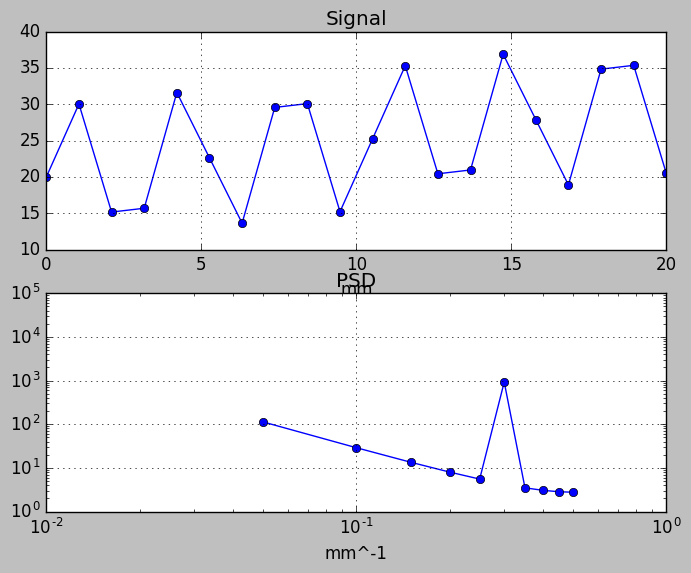

input profile:
signal rms is: 7.4422186392
rms**2= 55.3866182737
psd sum 1109.11740702
#--------------------


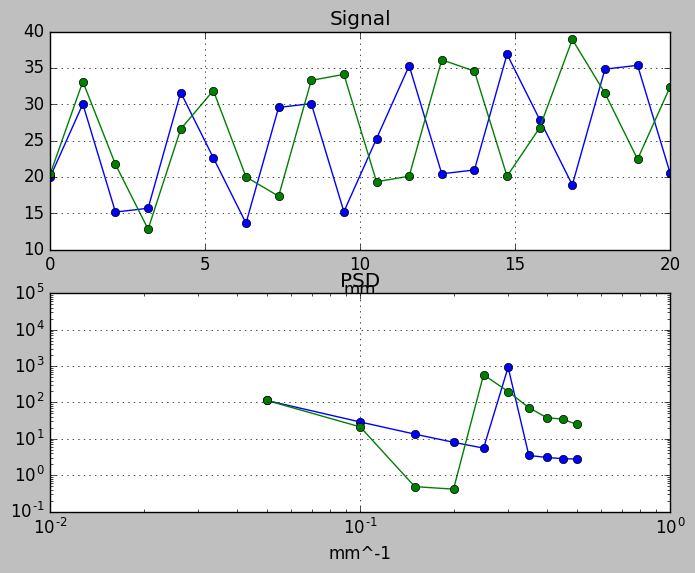

input profile:
signal rms is: 7.31399516271
rms**2= 53.4945252401
psd sum 1082.28139896
#--------------------


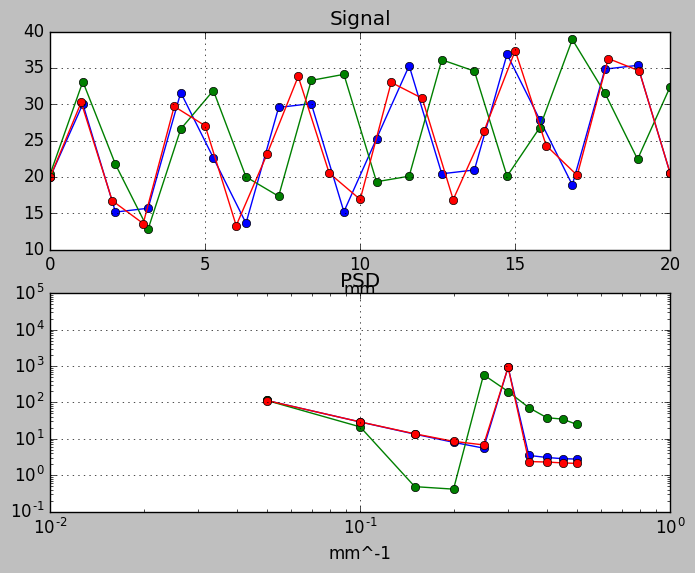

input profile:
signal rms is: 7.43819960529
rms**2= 55.3268133681
psd sum 1106.53626736
#--------------------


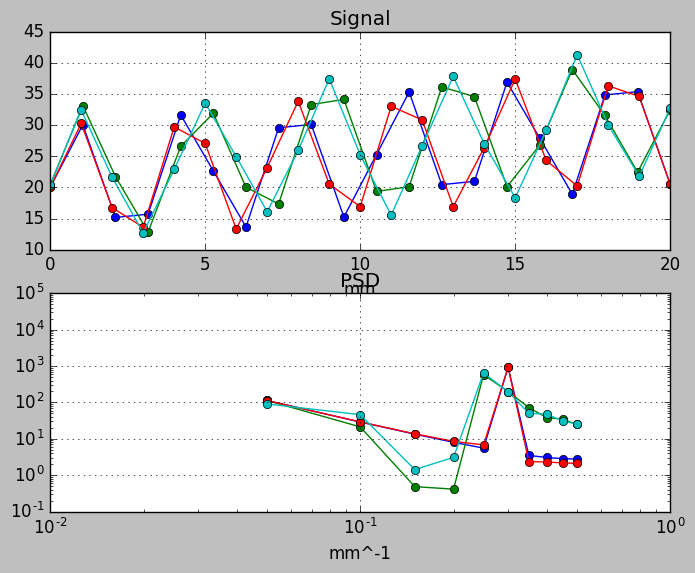

input profile:
signal rms is: 7.54317212055
rms**2= 56.8994456402
psd sum 1137.9889128
#--------------------


In [164]:
#reconstruction work perfectly.
# normalization is perfectly accurate for odd N, it fails by a few .1%
#    for even N. The discrepacy is not numerically relevant, but 
#    suspicious. Probably the way python includes the Nywuist freq.
#    for even N and the way I handle the normalization don't match.

def test_reconstruction(x1,y1):
    """Given a profile, calculate psd and phase, use them to reconstruct
    the profile and overplot it."""
    #plt.clf()
    f1,p1,ph1=psd(x1,y1,retall=True)
    axes=plot_sig_psd(x1,y1,marker='o',label='5.0',c='r')

    #rebuild profile 1
    x,y=psd2prof(f1,p1,ph1,N=len(x1))
    plot_sig_psd(x,y,marker='x',label='5.0',c='b')

    
    display(plt.gcf())
    print "input profile:"
    print "signal rms is:",np.std(y1)
    print "rms**2=",np.std(y1)**2
    print "psd sum",p1[1:].sum() #np.trapz(p/len(y),f)
    print '#--------------------'    
    print 'rms of reconstruction error:',np.std(y-y1)
    
def test_normalization(x1,y1):
    """Given a profile, vweify."""
    #plt.clf()
    f1,p1,ph1=psd(x1,y1,retall=True)
    axes=plot_sig_psd(x1,y1,marker='o',label='5.0')

    display(plt.gcf())
    print "input profile:"
    print "signal rms is:",np.std(y1)
    print "rms**2=",np.std(y1)**2
    print "psd sum",p1[1:].sum() #np.trapz(p/len(y),f)
    print '#--------------------'    
    return x,y,f1,p1,ph1

plt.figure()
plt.clf()
test_normalization(*make_signal(amp=10.,L=20.,N=20,
                                 nwaves=5.7,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=20,
                                 nwaves=5.,ystartend=(20,30),noise=3));

test_normalization(*make_signal(amp=10.,L=20.,N=21,
                                 nwaves=5.7,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=21,
                                 nwaves=5.,ystartend=(20,30),noise=3));

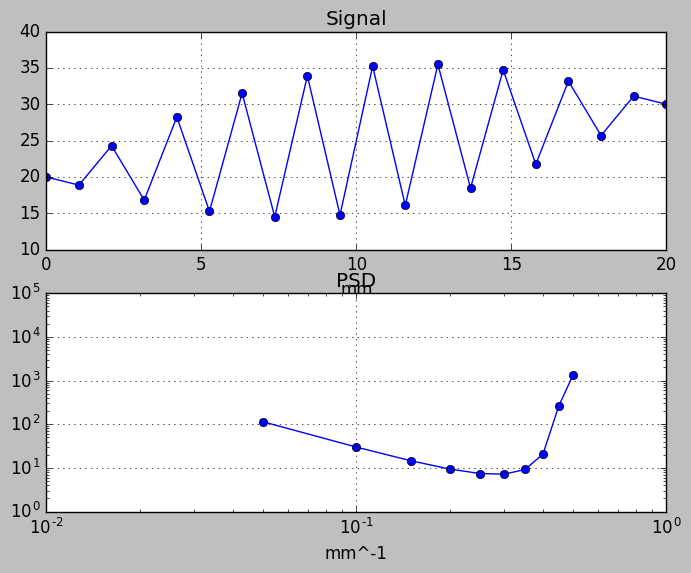

input profile:
signal rms is: 7.55809752041
rms**2= 57.124838128
psd sum 1808.57282756
#--------------------


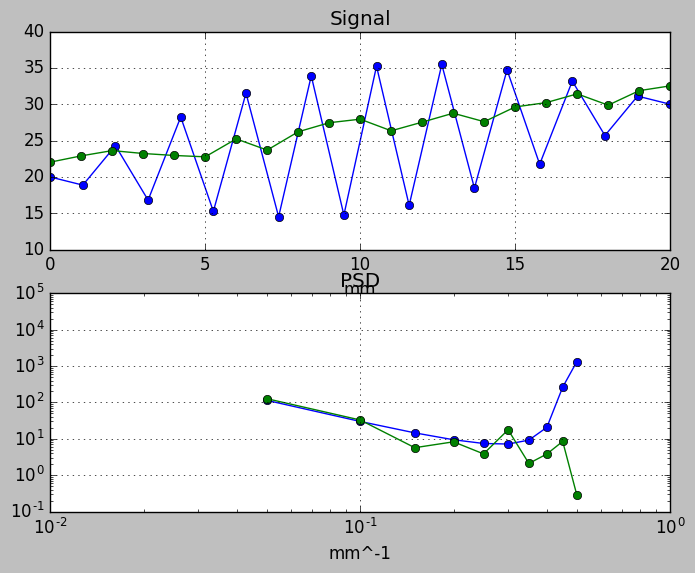

input profile:
signal rms is: 3.2381272627
rms**2= 10.4854681694
psd sum 209.709363388
#--------------------


In [165]:
#indeed the discrepacy is much larger (and numerically relevant)
#  when there is a signal with Nyquist frequency N/2

plt.figure()
plt.clf()
test_normalization(*make_signal(amp=10.,L=20.,N=20,
                                 nwaves=10.,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=21,
                                 nwaves=10.,ystartend=(20,30),noise=3));

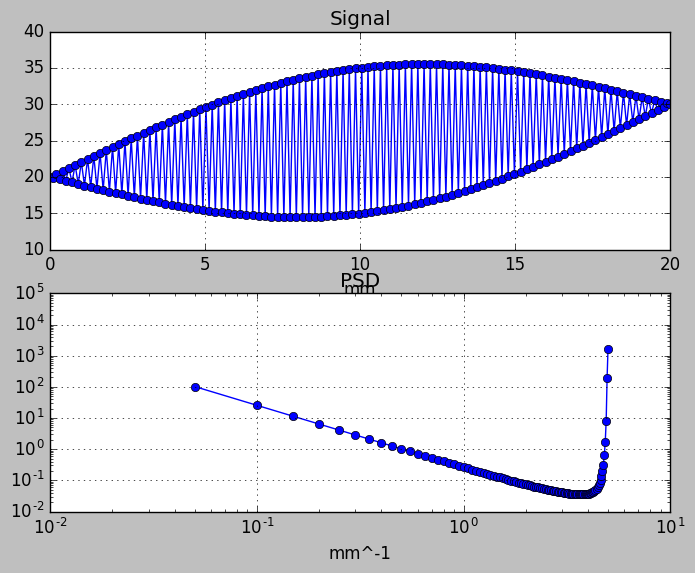

input profile:
signal rms is: 7.62699365632
rms**2= 58.1710322335
psd sum 1959.51791067
#--------------------


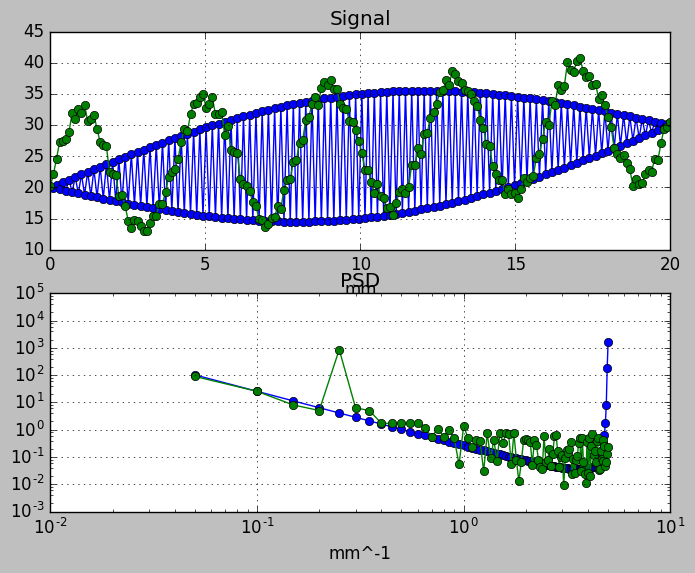

input profile:
signal rms is: 7.20953307187
rms**2= 51.9773671144
psd sum 1039.66041337
#--------------------


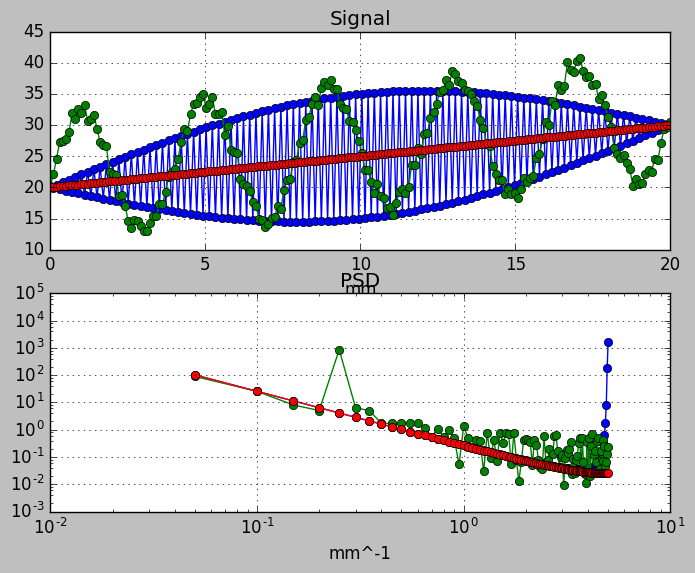

input profile:
signal rms is: 2.90114919759
rms**2= 8.41666666667
psd sum 168.333333333
#--------------------


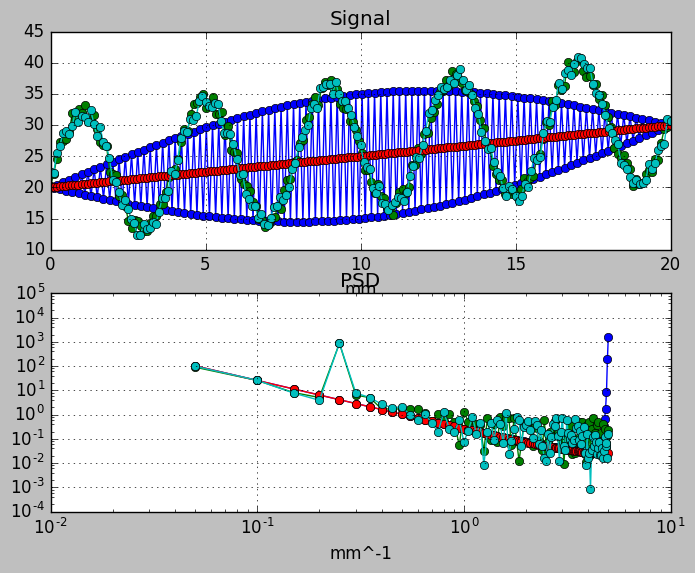

input profile:
signal rms is: 7.27153263177
rms**2= 52.8751868149
psd sum 1057.5037363
#--------------------


In [166]:
#but it can also be a sampling effect (e.g. aliasing, compare these 
# figures with the ones above). Note that for number of points much
# larger than max freq. (e.g. N=200 nwaves=10) all four tests give 
# perfect accuracy.


plt.figure()
plt.clf()
test_normalization(*make_signal(amp=10.,L=20.,N=200,
                                 nwaves=100,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=200,
                                 nwaves=5.,ystartend=(20,30),noise=3));

test_normalization(*make_signal(amp=10.,L=20.,N=201,
                                 nwaves=100,ystartend=(20,30),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=201,
                                 nwaves=5.,ystartend=(20,30),noise=3));

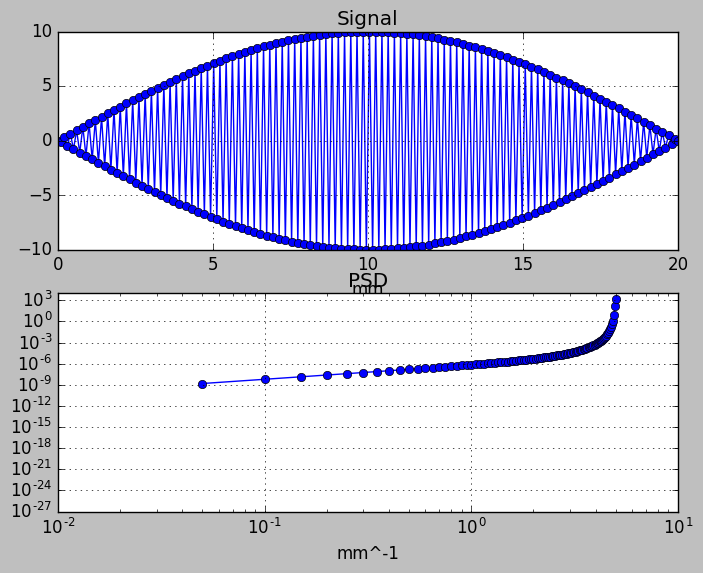

input profile:
signal rms is: 7.05336798983
rms**2= 49.75
psd sum 1797.45070556
#--------------------


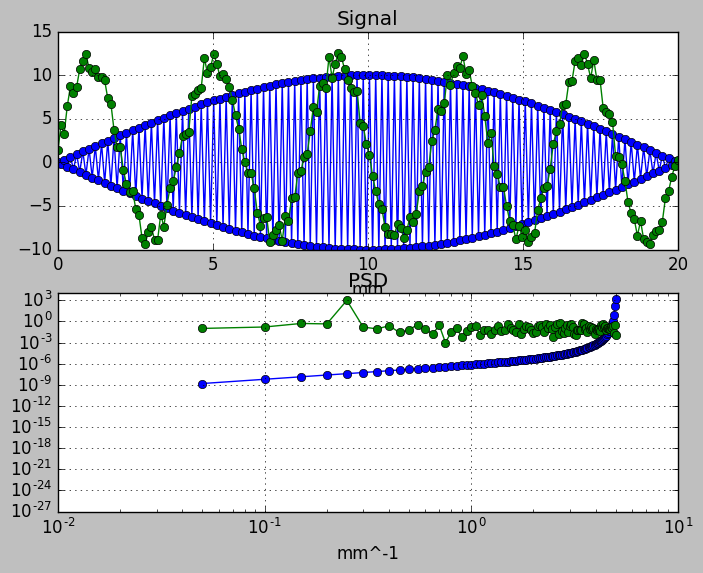

input profile:
signal rms is: 7.10954084346
rms**2= 50.5455710048
psd sum 1010.91693875
#--------------------


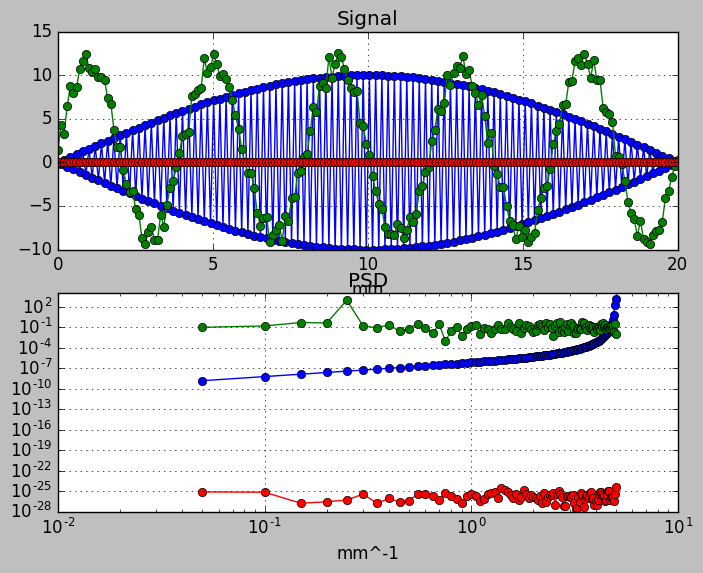

input profile:
signal rms is: 3.96524156001e-13
rms**2= 1.57231406292e-25
psd sum 3.14462812585e-24
#--------------------


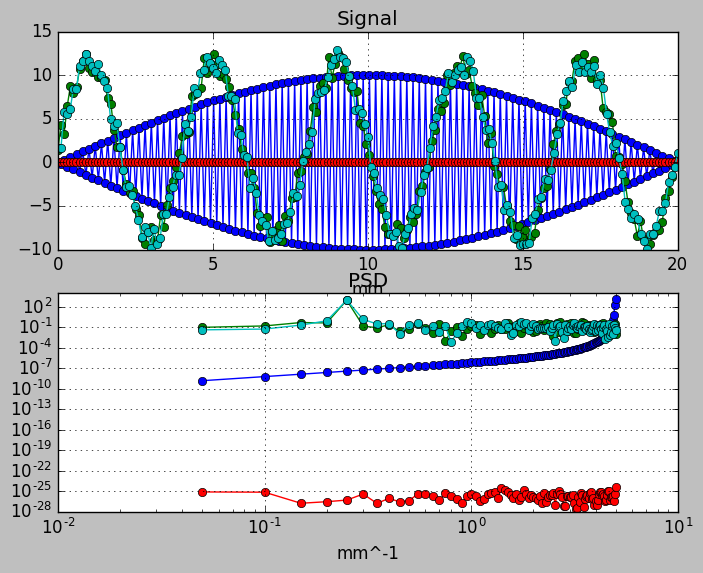

input profile:
signal rms is: 7.184780808
rms**2= 51.6210752589
psd sum 1032.42150518
#--------------------


In [167]:
#but it can also be a sampling effect (e.g. aliasing, compare these 
# figures with the ones above). Note that for number of points much
# larger than max freq. (e.g. N=200 nwaves=10) all four tests give 
# perfect accuracy.


plt.figure()
plt.clf()
test_normalization(*make_signal(amp=10.,L=20.,N=200,
                                 nwaves=100,ystartend=(0,0),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=200,
                                 nwaves=5.,ystartend=(0,0),noise=3));

test_normalization(*make_signal(amp=10.,L=20.,N=201,
                                 nwaves=100,ystartend=(0,0),noise=0));

test_normalization(*make_signal(amp=10.,L=20.,N=201,
                                 nwaves=5.,ystartend=(0,0),noise=3));

## End

In [168]:
#debug for development of psd2prof

#compare yfft frin direct transform of profile with the one from psd and phase.
N=len(x1)
#x1,y1=make_signal(amp=10.,L=30.,N=N,nwaves=5.,ystartend=(0,0),noise=0)
#f1,p1,ph1=psd(x1,y1,retall=True)

yfft=np.fft.rfft(y1)

p=p1/2  
p[0]=p[0]*2

print np.abs(yfft)
print np.sqrt(p)*N

print yfft
a= np.abs(yfft)*np.exp(1j*np.angle(yfft))
b= np.sqrt(p)*np.exp(1j*ph1)*N
print a
print b
print np.std(np.abs(a-yfft))
print np.std(np.abs(a-b))

NameError: name 'x1' is not defined

In [794]:
#debug for development of psd2prof

#compare yfft frin direct transform of profile with the one from psd and phase.
N=len(x1)
#x1,y1=make_signal(amp=10.,L=30.,N=N,nwaves=5.,ystartend=(0,0),noise=0)
#f1,p1,ph1=psd(x1,y1,retall=True)

yfft=np.fft.rfft(y1)

p=p1/2  
p[0]=p[0]*2

print np.abs(yfft)
print np.sqrt(p)*N

print yfft
a= np.abs(yfft)*np.exp(1j*np.angle(yfft))
b= np.sqrt(p)*np.exp(1j*ph1)*N
print a
print b
print np.std(np.abs(a-yfft))
print np.std(np.abs(a-b))

[  2.48689958e-14   2.32939624e+00   7.09769816e+00   4.31164524e+01
   2.50145178e+01   1.44721122e+01]
[  2.48689958e-14   2.32939624e+00   7.09769816e+00   4.31164524e+01
   2.50145178e+01   1.44721122e+01]
[ -2.48689958e-14 +0.j           6.56266758e-01 -2.23503932j
   3.83730533e+00 -5.97096365j   3.25852405e+01-28.23527165j
  -2.27540057e+01+10.39140622j  -1.43248069e+01 +2.0595963j ]
[ -2.48689958e-14 +3.04557360e-30j   6.56266758e-01 -2.23503932e+00j
   3.83730533e+00 -5.97096365e+00j   3.25852405e+01 -2.82352716e+01j
  -2.27540057e+01 +1.03914062e+01j  -1.43248069e+01 +2.05959630e+00j]
[ -2.48689958e-14 +3.04557360e-30j   6.56266758e-01 -2.23503932e+00j
   3.83730533e+00 -5.97096365e+00j   3.25852405e+01 -2.82352716e+01j
  -2.27540057e+01 +1.03914062e+01j  -1.43248069e+01 +2.05959630e+00j]
2.57681197468e-15
1.317797265e-15


In [769]:
#debug for development of psd2prof

#direct and inverse transform in real case

#x1,y1=make_signal(amp=10.,L=30.,N=10,nwaves=5.7,ystartend=(20,30),noise=0)
#f1,p1,ph1=psd(x1,y1,retall=True)

yfft=np.fft.rfft(y1)
yy=np.fft.irfft(yfft,N)
print y1
print yy

p=p1/2  
p[0]=p1[0]*2
p=np.sqrt(p)*np.exp(1j*ph1)*N
yyy=np.fft.irfft(p,N)
print yyy

[  0.00000000e+00   9.51056516e+00  -5.87785252e+00  -5.87785252e+00
   9.51056516e+00   2.14375088e-14  -9.51056516e+00   5.87785252e+00
   5.87785252e+00  -9.51056516e+00  -4.28750176e-14]
[  3.55271368e-15   9.51056516e+00  -5.87785252e+00  -5.87785252e+00
   9.51056516e+00  -3.10055012e-14  -9.51056516e+00   5.87785252e+00
   5.87785252e+00  -9.51056516e+00  -4.78001477e-14]
[  1.29189588e-15   9.51056516e+00  -5.87785252e+00  -5.87785252e+00
   9.51056516e+00  -3.10055012e-14  -9.51056516e+00   5.87785252e+00
   5.87785252e+00  -9.51056516e+00  -4.97379915e-14]


In [729]:
N*np.sqrt(p1/2)*np.exp(1j*ph1),np.fft.rfft(y1)

(array([  5.02429587e-15+0.j        ,  -1.68089747e-01+0.51732705j,
         -8.51667567e-01+1.17221984j,  -3.19450400e+00+2.32094301j,
         -2.13065069e+01+6.92290374j,   5.10415364e+01+0.j        ]),
 array([  7.10542736e-15+0.j        ,  -1.68089747e-01+0.51732705j,
         -8.51667567e-01+1.17221984j,  -3.19450400e+00+2.32094301j,
         -2.13065069e+01+6.92290374j,   5.10415364e+01+0.j        ]))

In [829]:
#test for normalization

plt.clf()
x1,y1=make_signal(amp=10.,L=30.,N=10,nwaves=5,ystartend=(0,0),noise=0)
f1,p1,ph1=psd(x1,y1,retall=True)

print "profile 1"
print "surface rms**2",np.std(y1)**2
print "psd sum",p1[1:].sum() #np.trapz(p/len(y),f)
print '#--------------------'

axes=plot_sig_psd(x1,y1,label='5.0',marker='o')
axes[-1].set_xscale('linear')



profile 1
surface rms**2 45.0
psd sum 77.1634374775
#--------------------


In [841]:

print 



77.1634374775


In [360]:
#positive freqs (including 0) are in f[:(N-1)/2+1]
# valid for both odd and even N, even if with this construction
# ir will always be odd

y=np.fft.ifft(p)
x=np.fft.fftfreq(len(y),f[1]-f[0])
#x[(N-1)/2+1:]=-x[:(N-1)/2:-1]+x[(N-1)/2]
x=np.fft.fftshift(x)
x=x-x[0]